# Programming Tutorial, Day 3
Part of the *Better With Scattering* Workshop by www.bam.de

### Loading data from day 2

In [ ]:
# Downloading the file to this working environment
#!wget https://github.com/BAMresearch/jupyter_tutorial_sas/raw/main/data/Ag_N008.dat

In [8]:
import pandas
fnData = "Ag_N008.dat"
dataframe = pandas.read_csv(fnData, sep='\s+', names=("q", "I", "uI"))
dataframe

,q,I,uI
0,0.030259,4769.301045,1655.363275
1,0.030719,5346.031551,2218.324041
2,0.031096,6387.856371,1534.356131
3,0.031611,2986.364914,1984.290104
4,0.032103,5634.075856,1367.733213
...,...,...,...
530,14.165907,0.036509,0.024799
531,14.334260,0.019789,0.024856
532,14.504613,0.036952,0.024934
533,14.676991,0.053573,0.025039


## Calculating and plotting a scattering model

### Scattering vector *Q*

Create a function *scattering_vector_q* (with `def`) for the scattering vector *Q* in small angle scattering:

$Q = {4\pi \over \lambda} \cdot sin({\theta\over2}{2\pi\over 360})$

With parameters for the angle $\theta$ (in degrees) and the wave length $\lambda$ (typically in nm).
Use functions from the numpy module preferably.  
The wave length can be set to a default value of 0.15406 nm for Copper K-α radiation.

### A sphere model for small-angle scattering

In small-angle scattering the form factor of a sphere is given by

$F(Q, r) = { 3 ~ sin(Qr) - Qr \cdot cos(Qr) \over (Qr)^3 }$

It describes the scattering amplitude of exact spherical scatterers of radius *r*.
The scattering intensity is the amplitude squared. Assuming the contrast is 1 (and thus the scattering length density difference), it can be simplified to:

$ I(Q, r) = F(Q, r)^2 $

1. Implement a function for calculating the intensity of spheres.
2. Use that function and the *Q*-vector from above to calculate the intensity of spheres of 25 nm radius and store it in a variable.

In [64]:
import numpy
def sphere(q, radius, N=1, eta=1):
  qr = numpy.outer(q, radius)
  qr = qr.flatten() if qr.shape[1] == 1 else qr
  return N * (3. * eta * (numpy.sin(qr) - qr * numpy.cos(qr)) / (qr**3.))**2

ff = sphere(dataframe.q, 25.)
#ff

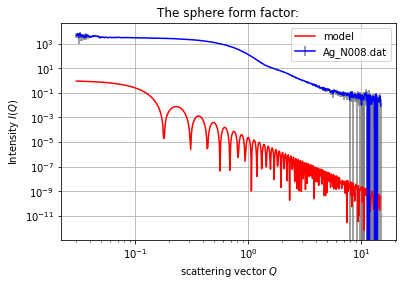

In [39]:
import matplotlib.pyplot as plt
plt.plot(dataframe.q, ff, label="model", color="red")
plt.errorbar(dataframe.q, dataframe.I, yerr=dataframe.uI, label=fnData,
             color="blue", ecolor="gray")
def prettyPlot():
  plt.xlabel("scattering vector $Q$")
  plt.ylabel("Intensity $I(Q)$")
  plt.title("The sphere form factor:")
  plt.xscale('log'); plt.yscale('log');
  plt.grid(True); plt.legend();
prettyPlot()

In [ ]:
#!pip install lmfit

In [43]:
from lmfit import Parameters
params = Parameters()
params.add("N",      value=1,  min=0, max=1e10, vary=True)
params.add("eta",    value=1,  min=0, max=1e10, vary=False)
params.add("radius", value=10, min=0, max=150,  vary=True)
params.pretty_print()

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
N              1        0    1e+10     None     True     None     None
eta            1        0    1e+10     None    False     None     None
radius        10        0      150     None     True     None     None


## Creating a model

In [45]:
from lmfit import Model
model = Model(sphere)

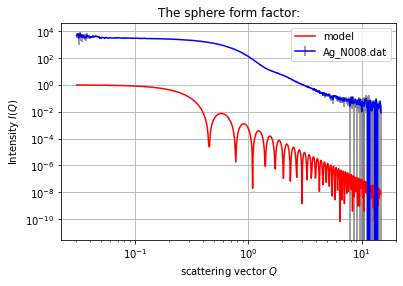

In [48]:
plt.errorbar(dataframe.q, dataframe.I, yerr=dataframe.uI, label=fnData,
             color="blue", ecolor="gray")
plt.plot(dataframe.q, model.eval(params, q=dataframe.q), label="model", color="red")
prettyPlot()

In [49]:
fitresult = model.fit(dataframe.I, params, q=dataframe.q, weights=1/dataframe.uI)

In [50]:
fitresult

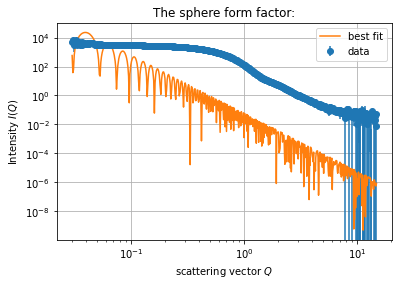

In [52]:
fitresult.plot_fit()
prettyPlot()

## Fitting a model with polydispersity to the data

### Create a probability density function (PDF)

1. Use this definition of the Log-Normal distribution function around the median:  

$${PDF}_{lognorm}(R, \sigma, R_{median})=\frac{1}{\sqrt{2\pi}\, \sigma R }e^{\frac{-\left(\ln{\frac{R}{R_{median}}}\right)^{2}}{2\sigma^{2}}}$$

2. And plot it with a $R_{median}=30$ and $\sigma=0.2$ over a linear range covering $\left[\;R_{min}, R_{max}\;\right]$ with $R_{min}=10^{-3}$ and $R_{max}=3 R_{median}$.

3. Calculate its integral using the generated and calculated values for $R$ and ${PDF}_{lognorm}$ as $x$ and $y$. It should be near to 1, depends on the number of intervals chosen for the linear range. Use the following integration routine:

In [53]:
def lognorm(x, sigma, r_median):
    return 1/(numpy.sqrt(2*numpy.pi)*sigma*x) * numpy.exp(-(numpy.log(x/r_median))**2 / (2*sigma*sigma))

In [60]:
import scipy
def integrate(xvec, yvec):
  return abs(scipy.integrate.simps(yvec, x=xvec))

The integral (area under the curve) is: 1.0


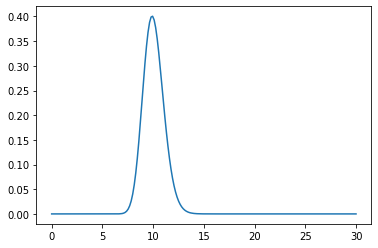

In [61]:
r_median, r_sigma, count = 10, .1, 200
x = numpy.linspace(1e-3, 3*r_median, count)
dist = lognorm(x, r_sigma, r_median)
plt.plot(x, dist)
print("The integral (area under the curve) is:", integrate(x, dist))

### Update the model first and plot it

The sphere model gets a additional parameters for the median radius $R_{median}$ and the distribution width $\sigma$. To weigh the model by the distribution, it has to be integrated over the range of radii from $R_{min}$ to $R_{max}$:

$$I_{poly}(Q, \eta, N, \sigma, R_{median}) = \int_{R_{min}}^{R_{max}} {PDF}_{lognorm}(r, \sigma, R_{median}) \; I(Q, N, \eta, r) \; \textrm{d}r$$

With $I(Q, N, \eta, r)$ from the previous exercise:

$$I(Q, N, \eta, r) = N \left[ { 3 ~ \eta ~ [sin(Qr) - Qr \cdot cos(Qr)] \over (Qr)^3 } \right]^2$$

For every single *Q* value, this integral has to be calculated. Plot the (now polydisperse) sphere model with the *Q* values loaded from file.

In [65]:
def sphere_pd(q, r_median, r_sigma, N=1, eta=1):
  radius = numpy.linspace(1e-3, 3*r_median, 100)
  weight = lognorm(radius, r_sigma, r_median)
  sph = weight*sphere(q, radius, N, eta)
  return N * integrate(radius, sph)

In [67]:
r_median=10; r_sigma=.05; N=1; eta=1
sphere_pd(dataframe.q, r_median, r_sigma, N, eta)

from lmfit import Model
model = Model(sphere_pd)

In [68]:
params.add("r_median", value=10,  min=0,  max=150,  vary=True)
params.add("r_sigma",  value=0.1,  min=0,  max=.5,   vary=True)
if "radius" in params:
    params.pop("radius")
params

name,value,initial value,min,max,vary
N,1.00000000,1,0.00000000,1.0000e+10,True
eta,1.00000000,1,0.00000000,1.0000e+10,False
r_median,10.0000000,10,0.00000000,150.000000,True
r_sigma,0.10000000,0.1,0.00000000,0.50000000,True


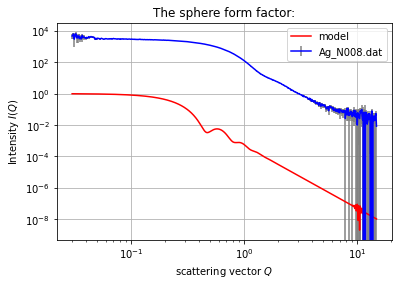

In [69]:
plt.errorbar(dataframe.q, dataframe.I, yerr=dataframe.uI, label=fnData,
             color="blue", ecolor="gray")
plt.plot(dataframe.q, model.eval(params, q=dataframe.q), label="model", color="red")
prettyPlot()

In [70]:
fitresult = model.fit(dataframe.I, params, q=dataframe.q, weights=1/dataframe.uI)
fitresult

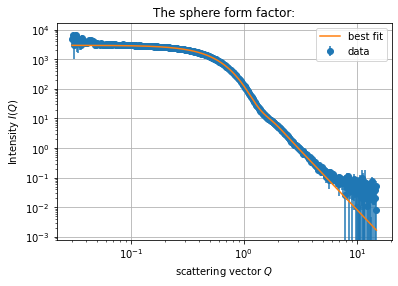

In [73]:
fitresult.plot_fit(fit_kws=dict(zorder=5))
prettyPlot()